# Notebook 04: Exploratory Data Analysis of Transcripts

**Project: Data Triage of Transcribed Nixon Tapes** <br>
*Michelle Ballard and April Crompton* <br>
Loyola University Maryland Data Science Project 

## Import statements

In [1]:
import os
import pickle
import pandas as pd
import re
from string import punctuation
from collections import Counter, defaultdict
from datetime import datetime

import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.dates
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from nltk import pos_tag
from nltk import RegexpParser
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# unpickle preserved dataframes to continue EDA and Statistical Analysis
pkl_file = open('cleaned_combined.pkl', 'rb')

df_all_combined = pickle.load(pkl_file)
print(df_all_combined.info())

df_speakers_combined = pickle.load(pkl_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   exhibit                88 non-null     object         
 1   corpus                 88 non-null     object         
 2   conversation_number    88 non-null     object         
 3   cassette_number        88 non-null     object         
 4   abstract               31 non-null     object         
 5   location               88 non-null     object         
 6   participants           88 non-null     object         
 7   minutes                88 non-null     object         
 8   txtdate                88 non-null     object         
 9   date                   88 non-null     datetime64[ns] 
 10  start_dtime            88 non-null     datetime64[ns] 
 11  end_dtime              88 non-null     datetime64[ns] 
 12  time_diff              88 non-null     timedelta64[n

In [3]:
# set font size for figures
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# ref Pedro M Duarte https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

### Explore Exhibits over time

In [4]:
# Get unique names
uniq = sorted(list(set(df_all_combined['corpus'])), reverse=True)
print(uniq)

# Set the color map to match the number
z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)
mark = ['.','o']

['WSPF', 'WG_Trial']


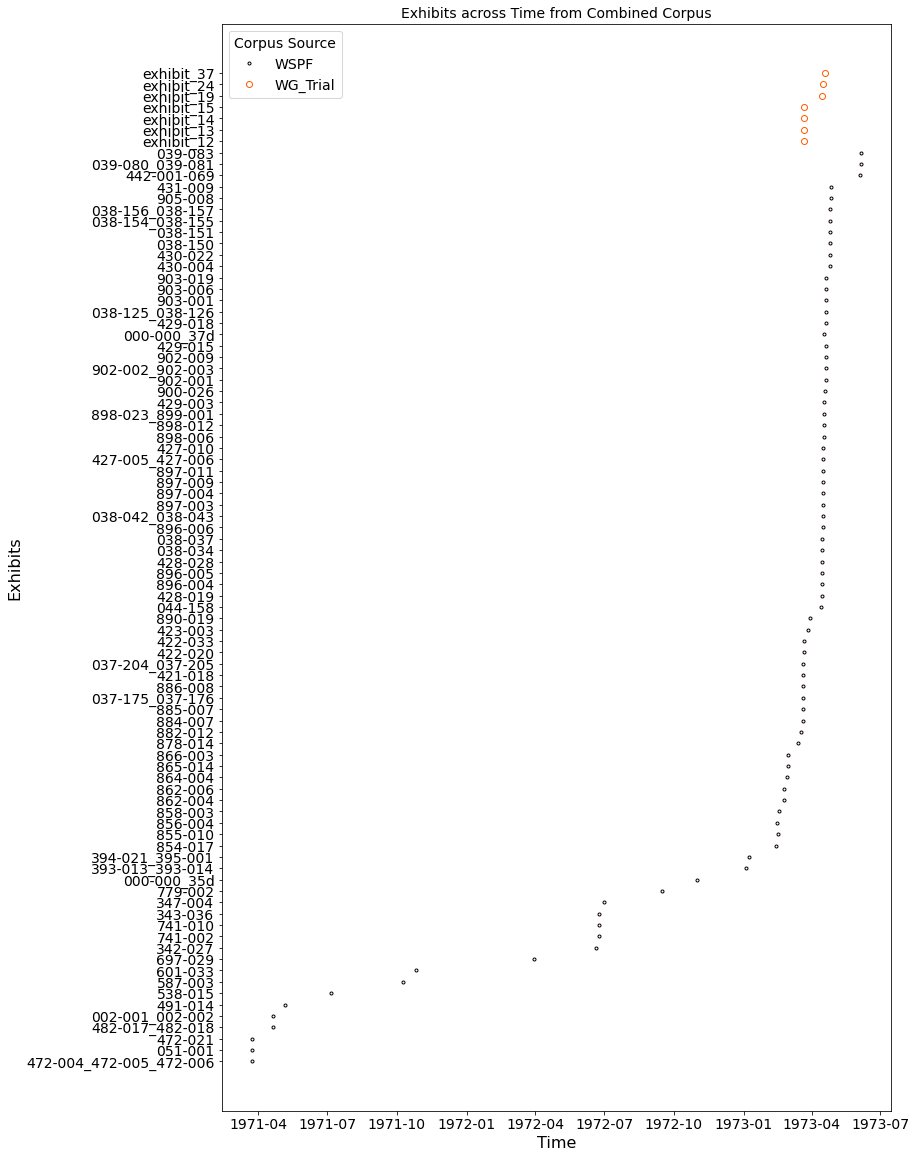

In [5]:
x_values = df_all_combined['start_dtime']
y_values = df_all_combined['exhibit']
plt.figure(figsize=(12, 20))
dates = matplotlib.dates.date2num(x_values)

# Set the color map to match the number
z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)
mark = ['.','o']

# Plot each 
for i in range(len(uniq)):
    indx = df_all_combined['corpus'] == uniq[i]
    plt.plot_date(x_values[indx], y_values[indx], color=scalarMap.to_rgba(i), 
                  label=uniq[i], fmt=mark[i], fillstyle='none')

plt.xlabel('Time')
plt.ylabel('Exhibits')
plt.title('Exhibits across Time from Combined Corpus')
plt.legend(loc='upper left', title = "Corpus Source")
plt.show()

### Explore amount of time

304.0


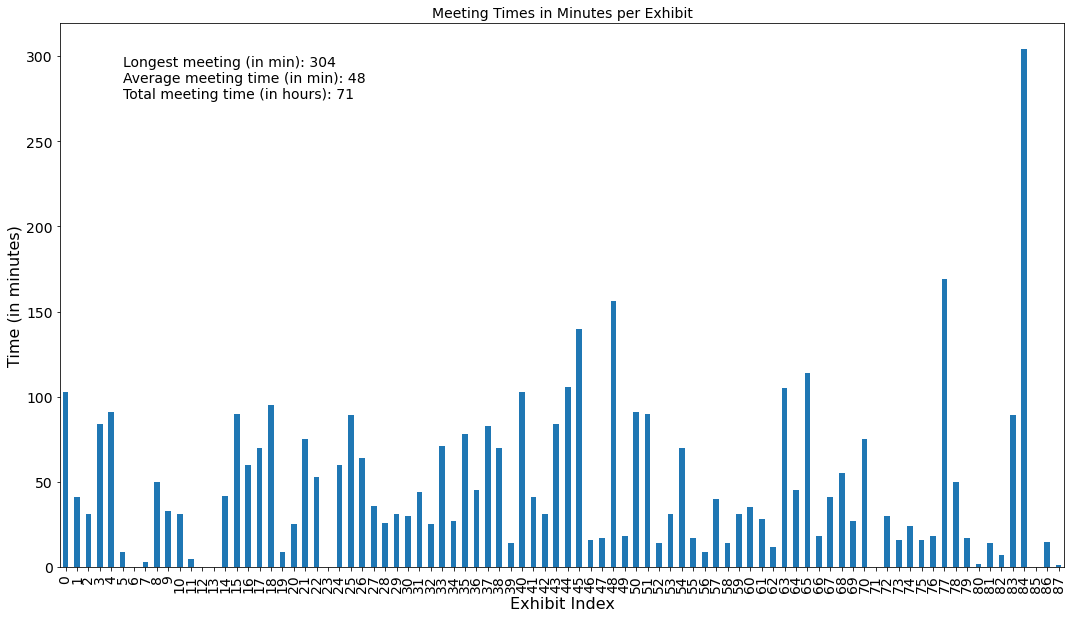

In [38]:
# which meetings took more or less time in minutes
plt.figure(figsize=(18, 10))
plt.xlabel('Exhibit Index')
plt.ylabel('Time (in minutes)')
plt.title('Meeting Times in Minutes per Exhibit')

meeting_max = str(round(max(all_mins)))
meeting_mean = str(round(np.mean(all_mins)))
mean_total = str(round(sum(all_mins)/60))

all_mins = df_all_combined.time_diff.dt.total_seconds()/60
plt.text(5,275, 'Longest meeting (in min): ' + meeting_max + '\nAverage meeting time (in min): ' + meeting_mean + '\nTotal meeting time (in hours): ' + mean_total )
print(max(all_mins))
all_mins.plot.bar();



### Explore Locations

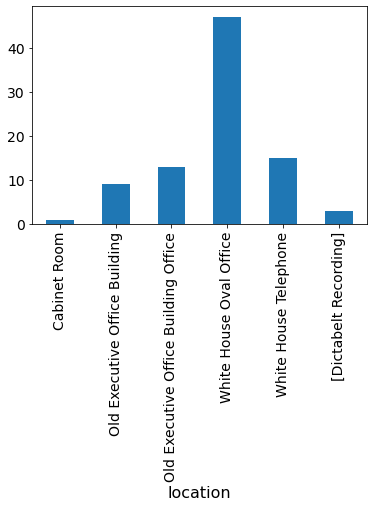

In [39]:
# examining the frequency of locations present in data
locations = df_all_combined.groupby("location")["exhibit"].count()
locations.plot.bar();

## Explore the effects of Preprocessing

### Set up preprocessing
**Methods:**
1. POS Tagging
2. Use Ngrams
3. Stemming
4. Remove Stopwords
5. Remove Punctuation


In [41]:
# generate a stopwords list and extend to clean up commonly used words in news reports

stop_words = stopwords.words('english')
stop_words.extend(['uh'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [42]:
# Build parser to do sentence parsing, word parsing, and POS tagging
# pulled from NLP text book, Chapter 7

def ie_preprocess(text):
    sentences = sent_tokenize(text)
    sentences = [word_tokenize(sent) for sent in sentences]
    sentences = [pos_tag(sent) for sent in sentences]
    return sentences

### Explore parts of speech

In [47]:
%%time 
all_speech_final = df_all_combined['speech_final']
print(len(all_speech_final))

# Tag transcripts with POS
all_Tagged = [ie_preprocess(r) for r in all_speech_final]
print(len(all_Tagged))
print(type(all_Tagged[1][1][1][1]))
# list of list of tuple of str

88
88
<class 'str'>
Wall time: 52.2 s


In [45]:
# Examine the tagged entities from tagged transcripts

count_tags = defaultdict(int)

for review, sentence in enumerate(all_Tagged):
    # print(f'\n Review: {review}')  #uncomment for data inspection
    for ls, tp in enumerate(sentence):  
        for index, tuple in enumerate(tp):     
            element_one = tuple[0]
            element_two = tuple[1]
            count_tags[element_two] += 1
            #print(f' {element_two}  ---  {element_one} ')   # uncomment for data inspection

print(count_tags)

defaultdict(<class 'int'>, {'NNP': 36707, ',': 62168, 'VBD': 22966, 'RB': 42834, 'VB': 33969, 'RP': 3659, '.': 47024, 'JJ': 23387, 'NN': 54888, 'WP': 5721, 'VBZ': 23108, 'DT': 55001, 'IN': 54203, 'PRP': 73527, 'CC': 20179, 'WRB': 3433, 'VBG': 8997, 'NNS': 10659, 'UH': 11735, 'VBN': 9113, 'PRP$': 4683, 'TO': 16774, ':': 12483, 'JJR': 876, 'MD': 13181, 'VBP': 27462, '``': 2688, "''": 1780, 'JJS': 617, 'POS': 2343, 'CD': 4124, 'WDT': 2721, 'EX': 2035, 'PDT': 642, 'RBS': 108, 'NNPS': 277, 'RBR': 353, ')': 22, 'FW': 163, '$': 67, 'SYM': 7, '#': 3, 'WP$': 10, 'LS': 2})


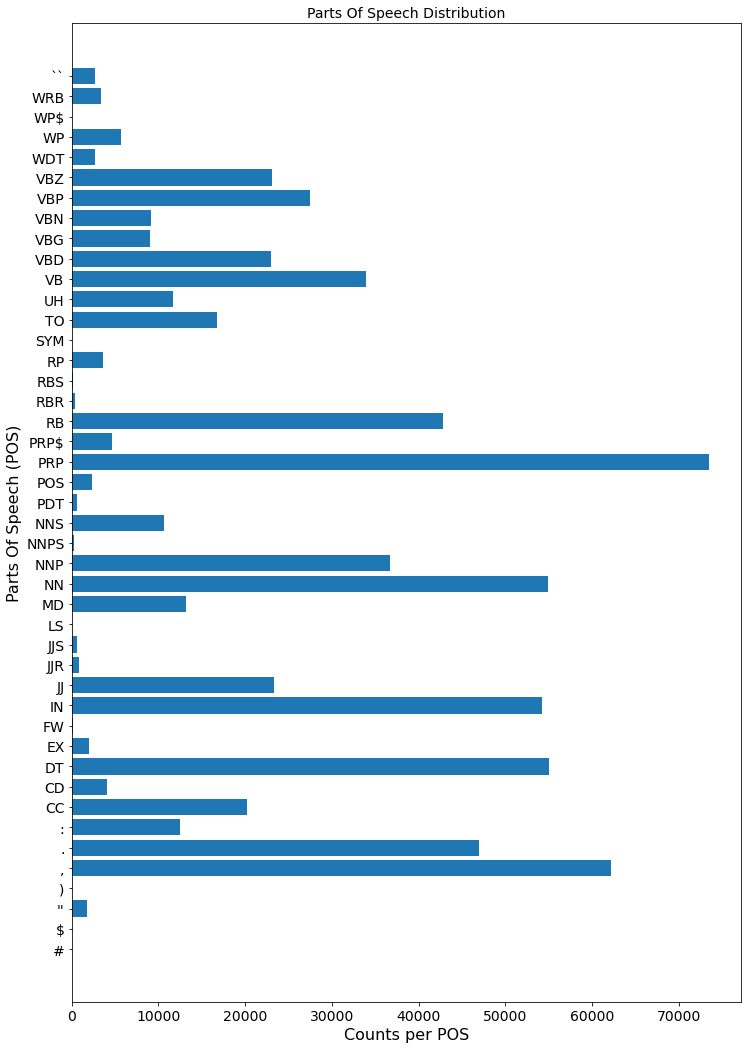

In [46]:
# wanted to get a better understanding of how often the different tags appear

plt.figure(figsize=(12, 18))
plt.barh(*zip(*sorted(count_tags.items())))
plt.xlabel('Counts per POS')
plt.ylabel('Parts Of Speech (POS)')
plt.title('Parts Of Speech Distribution')
plt.show()

# We see that PRPs are the most frequent tag and lots of punctuation tags as well - Pronouns
# Commas and periods are also very frequent
# These create a great deal of noise

In [57]:
# examine just the NNP tags - Proper Nouns
import pprint
NNP_set = set()

for review, sentence in enumerate(all_Tagged):
   # print(f'\n Review: {review}')
    for ls, tp in enumerate(sentence):  
        for index, tuple in enumerate(tp):
            element_one = tuple[0]
            element_two = tuple[1]
            if element_two == 'NNP' or element_two == 'NNPS':  #change here to tag of interest(s)
                #print(f' {element_two}  ---  {element_one} ')
                NNP_set.add(element_one)

                

print("Size of Unique NNPS: ", len(NNP_set))
print(sorted(NNP_set))


Size of Unique NNPS:  2611
["'60", "'62", "'64", "'68", "'69", "'70", "'71", "'72", "'74", "'The", "'Well", "'cause", "'em", "'hell", "'member", "'til", "'well", '*', ',I', ',now', "-'cause", '-.uh', '-10', '-107-', '-109-', '-114-', '-115-', '-117', '-118', '-12-', '-121', '-128-', '-13', '-13-', '-132-', '-147-', '-149-', '-15-', '-16', '-162-', '-163-', '-17-', '-18-', '-2', '-21-', '-22-', '-24-', '-25', '-27-', '-28', '-3', '-3-', '-31-', '-32', '-32-', '-36-', '-4', '-4-', '-42-', '-43-', '-45', '-46-', '-47-', '-48-', '-53', '-54-', '-60-', '-63', '-64-', '-67', '-71', '-71-', '-73-', '-74-', '-76', '-76-', '-79-', '-8', '-8-', '-82-', '-83', '-87-', '-9', '-90-', '-91-', '-96-', '-And', '-Bob', '-But', '-Colson', '-DIck', '-Dean', '-Dean-Ehrlichman', '-Did', '-Ellsberg', '-Garment', '-Gordon', '-Haldeman', '-He', '-Here', '-Huh', '-Hunt', '-I', '-In', '-It', '-John', '-MacGregor', '-Muskie', '-No', '-Oh', '-Pepsi', '-Petersen', '-President', '-Remember', '-Republicans', '-Ron',

In [58]:
# Chunker for Named Entities


cp2 = RegexpParser('NamedEntity: {<NNP>{3,}}')  # CHUNK: {<V.*> <TO> <V.*>}

# Check named entities per transcript
for review, sentence in enumerate(all_Tagged):
    print(f'\nReview {review} NamedEntities:')
    for i, sent in enumerate(sentence):
        tree = cp2.parse(sent)
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'NamedEntity'):
            print('\t'," ".join([tok for tok, pos in subtree.leaves()]))


Review 0 NamedEntities:
	 American Civil Liberty Union
	 New York City
	 'The White House
	 Tile Grand Jury
	 Burning Tree Country Club
	 F. Lee Bailey
	 F. Lee B-
	 No White House
	 U. S. Attorney
	 Grand Ju ..
	 U. S. Attorney
	 U. S. Attorney
	 Sirica Delays Sentencing Watergate

Review 1 NamedEntities:
	 Deputy Attorney General
	 White House Counsel
	 Dear Senator Ervin

Review 2 NamedEntities:
	 * * * * * * * * * *

Review 3 NamedEntities:
	 * * * * * * * * Right
	 HALDE MAN That
	 REEL TWO BEGINS Unintelligible
	 * * * * * * * * * Does Dean
	 REEL ONE Uh

Review 4 NamedEntities:
	 HALDEMAN John Dean
	 * * * * * * * Part II
	 * * * * * * * * * Could
	 * * * * * * * *

Review 5 NamedEntities:

Review 6 NamedEntities:

Review 7 NamedEntities:

Review 8 NamedEntities:
	 Paul Affeldt Yeah
	 John Paul Hammerschmidt
	 South Carolina Kentucky
	 Ezra Benson No

Review 9 NamedEntities:
	 Maybe John Ehrlichman
	 Consumer Price Index

Review 10 NamedEntities:
	 O ’ Hara
	 Guam Regional Offi

In [61]:
# Find verb to verb phrases, may provide action-based insight? 

cp3 = RegexpParser('VerbtoVerb: {<V.*> <TO> <V.*>}')  # CHUNK: {<V.*> <TO> <V.*>}

for review, sentence in enumerate(all_Tagged[:3]):
    print(f'\nReview {review} Verb to Verb:')
    for i, sent in enumerate(sentence):
        tree = cp3.parse(sent)
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'VerbtoVerb'):
            print('\t'," ".join([tok for tok, pos in subtree.leaves()]))
                


Review 0 Verb to Verb:
	 was to be
	 going to do
	 going to talk
	 going to do
	 tried to hold
	 continue to be
	 like to turn
	 going to be
	 like to see
	 got to know
	 going to start
	 had to perjure
	 told to look
	 told to put
	 like to have
	 going to lay
	 told to go
	 trying to get
	 like to say
	 going to have
	 got to stay
	 going to be
	 tried to come
	 came to see
	 going to use
	 were to blow
	 helped to get
	 going to go
	 going to infiltrate
	 wanted to press
	 had to piece
	 starting to make
	 want to know
	 want to know
	 said to be
	 going to hang
	 going to be
	 had to have
	 going to be
	 going to bug
	 going to do
	 try to hold
	 going to be
	 going to be
	 got to get
	 got to say
	 got to have
	 had to be
	 had to be
	 going to pass
	 got to give
	 had to go
	 got to have
	 had to tell
	 pay to let
	 going to be
	 ask to meet
	 wanted to know
	 wanted to talk
	 going to be
	 going to be
	 got to be
	 hate to learn
	 had to be
	 trying to run
	 wanted to run
	 wan

In [62]:
# find adjectives (may provide sentiment insight)

cp4 = RegexpParser('Adjectives: {<JJ.*>}')  # JJ: adjectives

for review, sentence in enumerate(all_Tagged[:3]):
    print(f'\nReview {review} Adjectives:')
    for i, sent in enumerate(sentence):
        tree = cp4.parse(sent)
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'Adjectives'):
            print('\t'," ".join([tok for tok, pos in subtree.leaves()]))
                


Review 0 Adjectives:
	 Good
	 consistent
	 further
	 full
	 more
	 enough
	 own
	 unwilling
	 stubborn
	 stubborn
	 smart
	 smart
	 own
	 typical
	 right
	 own
	 honest
	 much
	 conscious
	 other
	 little
	 only
	 responsible
	 raw
	 unwise
	 raw
	 innocent
	 damaging
	 further
	 some-time
	 available
	 busy
	 right
	 difficult
	 right
	 other
	 overall
	 first
	 other
	 clear
	 other
	 like
	 basic
	 first
	 peripheral
	 legitimate
	 original
	 old
	 normal
	 informa-
	 bad
	 cautious
	 back-
	 aware
	 sensitive
	 good
	 good
	 proper
	 interested
	 happy
	 incredible
	 involved
	 black
	 incredible
	 other
	 sat
	 incredible
	 draw-ing
	 realistic
	 second
	 tail
	 first
	 long
	 like
	 nice
	 right
	 whole
	 present
	 last
	 absurd
	 hard
	 other
	 Other
	 many
	 other
	 legal
	 much
	 illegal
	 absurd
	 close
	 good
	 good
	 soft
	 independent
	 other
	 next
	 proper
	 different
	 Democratic
	 next
	 aware
	 McGovern
	 illegal
	 next
	 aware
	 Democratic
	 anybody-
	 name-this
	 m

In [63]:
# Find descriptions/possive natures of Named Entities

cp5 = RegexpParser('PossessiveNouns: {<DT|PRP\$|WP\$>?<JJ.*>*<NNP>{2,}}')  # DT: the, *.$ possessives or JJ adjective and NNP NamedEntity

for review, sentence in enumerate(all_Tagged[:3]):
    print(f'\nReview {review} Possessive or Adjective NamedEntities:')
    for i, sent in enumerate(sentence):
        tree = cp5.parse(sent)
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'PossessiveNouns'):
            print('\t'," ".join([tok for tok, pos in subtree.leaves()]))
                


Review 0 Possessive or Adjective NamedEntities:
	 the Attorney General
	 Pat Gray
	 the White House
	 Sam Ervin
	 The American Civil Liberty Union
	 Bob Haldeman
	 the Re-election Committee
	 Jack Caulfield
	 PRES Yeah
	 an old New York City
	 Gordon Liddy
	 the White House
	 the White House
	 the White House
	 the Attorney General
	 The Unite House
	 Chuck Colson
	 Chuck Colson
	 Unless Hunt
	 Unless Hunt
	 Did Colson
	 the White House
	 the Democratic National Committee
	 the Democratic National Committee
	 the White House
	 'The White House
	 The White House
	 The White House
	 Mc G-
	 Mc Govern
	 Larry O'Brien
	 Larry O'Brien
	 the Grand Jury
	 the Grand Jury
	 the Grand Jury
	 the Grand Jury
	 the Grand Jury
	 the Grand Jury
	 the Grand Jury
	 the Grand Jury
	 The Assistant U.S
	 the Grand Jury
	 the Grand Jury
	 Tile Grand Jury
	 the Grand Jury
	 the Grand Jury
	 the White House
	 Henry Petersen
	 Burning Tree Country Club
	 a Cuban Committee
	 a Cuban Committee
	 Hunt ’
	 DEAN 

In [64]:
# build function to pull top 30 POS from dataset

def getTop30POS(_data, _regp, _label):

    cp6 = RegexpParser(_regp)  # i.e. NamedEntity: {<NNP>{3,}}
    count_tags5 = defaultdict(int)
    
    for review, sentence in enumerate(_data):
        for i, sent in enumerate(sentence):
            if sent:
                tree = cp6.parse(sent)
                for subtree in tree.subtrees(filter=lambda t: t.label() == _label):
                    NE = " ".join([tok for tok, pos in subtree.leaves()])
                    count_tags5[NE] += 1
    top30_NE = sorted(count_tags5.items(), key=lambda x: x[1], reverse=False)
    return(top30_NE[-30:])


In [65]:

regp = 'NamedEntity: {<NNP>{3,}}'
regp1 = 'VerbToVerb: {<V.*> <TO> <V.*>}'
label = 'NamedEntity'
label1 = 'VerbToVerb'
regp2 = 'Adjectives: {<JJ.*>}'
label2 = 'Adjectives'


In [66]:
%%time
# get top 30 for sentiment 0
all_Tagged_topNE = getTop30POS(all_Tagged, regp, label)
print(all_Tagged_topNE)


[('White House Police', 2), ('Assistant Attorney General Petersen', 2), ('Did John Dean', 2), ('Technical Security Division', 2), ('“ D ” Right', 2), ('U. S. Attorneys', 2), ('BULL AND Well', 2), ('“ D ” Well', 3), ('RESTRICTED- “ D', 3), ('RESTRICTED- “ D ” Yeah', 3), ('“ D ” RESTRICTED- “ D ”', 3), ('White House Staff', 3), ('RESTRICTED- “ B', 4), ('Washington Field Office', 4), ('Edward Bennett Williams', 4), ('O ’ Brien', 4), ('“ D ” Yeah', 4), ('Grand Jury. ”', 4), ('New York City', 5), ('F. Lee Bailey', 5), ('Deputy Attorney General', 5), ('MITCHELL AND EHRLICHMAN ON', 5), ('U. S. Attorney', 7), ('White House Counsel', 7), ('BETWEEN PRESIDENT NIXON', 7), ('RESTRICTED- “ B ”', 7), ('Assistant Attorney General', 12), ('“ D ”', 17), ('RESTRICTED- “ D ”', 19), ('New York Times', 22)]
Wall time: 1.88 s


In [67]:
%%time
all_Tagged_topVtoV = getTop30POS(all_Tagged, regp1, label1)
print(all_Tagged_topVtoV)

[('have to have', 26), ('got to know', 27), ('going to take', 27), ('have to get', 30), ('gon na do', 30), ('gon na be', 30), ('had to be', 32), ('have to go', 32), ('gon na get', 32), ('have to say', 32), ('want to know', 36), ('got to do', 48), ('going to come', 49), ('want to do', 49), ('got to have', 50), ('want to talk', 50), ('want to get', 50), ('has to be', 54), ('have to be', 58), ('want to be', 59), ('going to go', 60), ('have to do', 62), ('going to say', 69), ('got to get', 70), ('trying to get', 81), ('going to get', 82), ('got to be', 103), ('going to do', 113), ('going to have', 125), ('going to be', 266)]
Wall time: 1.9 s


In [68]:
%%time
all_Tagged_topAdj = getTop30POS(all_Tagged, regp2, label2)
print(all_Tagged_topAdj)

[('new', 140), ('big', 149), ('public', 152), ('important', 153), ('wrong', 161), ('next', 169), ('great', 176), ('Good', 177), ('hard', 177), ('s', 177), ('bad', 199), ('true', 211), ('better', 211), ('least', 222), ('own', 223), ('same', 248), ('much', 273), ('more', 280), ('last', 283), ('first', 287), ('only', 300), ('’', 313), ('little', 379), ('forth', 403), ('uh', 437), ('whole', 448), ('sure', 454), ('good', 669), ('other', 1217), ('right', 1564)]
Wall time: 2.05 s


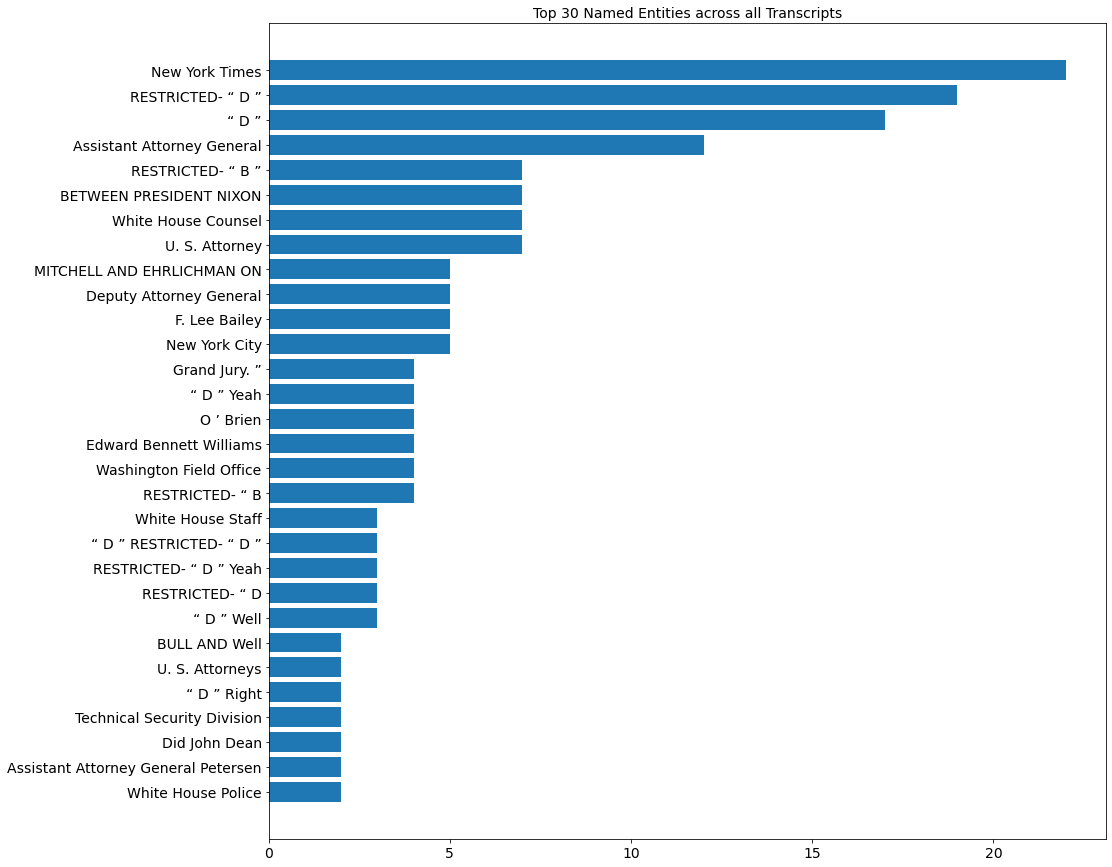

In [69]:
# plot top 30 Named Entities across sentiments
x0, y0 = zip(*(all_Tagged_topNE))

f, (ax1) = plt.subplots(1, 1, sharex=True, figsize=(15, 15))
#f.subplots_adjust(wspace=1)

ax1.barh(x0,y0)
ax1.set_title("Top 30 Named Entities across all Transcripts");
#f.show()

#### Explore parts of speech after eliminating stop-words and some punctuation

In [70]:
# Add Stop Words, include symbols, br, <br /> statemetns, etc.

Stop_words = stopwords.words('english') + list(punctuation) +  ["uh", "...","''",':', '#' '$', '``', ' ', '”',]
stop_word_caps = [word.capitalize() for word in Stop_words]
Stop_words = Stop_words + stop_word_caps

Stop_words2 = list(punctuation)

In [71]:
# Create custom word tokenizer to use stopwords and regex to improve parsing

def wordtokenizer(text):
    terms = word_tokenize(text)
    # filter stop words
    terms = [w for w in terms if w not in Stop_words]
    # remove contractions, best way might be having a list 
    terms = [w for w in terms if re.search(r'([a-zA-Z:]|[\s,.\'\":]|\d+)', w)]        
    return terms

# Build parser to do sentence parsing, word parsing, and POS tagging
# This uses the wordtokenizer above, which filters punctation, stopwords, and contractions

def preprocess_customtokenizer(text):
    sentences = sent_tokenize(text)
    sentences = [wordtokenizer(sent) for sent in sentences] # filter stopwords, remove contractions
    sentences = [pos_tag(sent) for sent in sentences]
    return sentences

In [75]:
%%time
# Tag transcripts with POS after limited preprocessing
all_Tagged2 = [preprocess_customtokenizer(r) for r in all_speech_final]
print(len(all_Tagged2))
print(type(all_Tagged2[1][1][1][1]))
# list of list of tuple of str

88
<class 'str'>
Wall time: 45.6 s


In [76]:
%%time
# Examine tags after improved parsing
count_tags2 = defaultdict(int)

for review, sentence in enumerate(all_Tagged2):
  #  print(f'\n Review: {review}')
    for ls, tp in enumerate(sentence):  
        for index, tuple in enumerate(tp):     
            element_one = tuple[0]
            element_two = tuple[1]
            count_tags2[element_two] += 1
            #print(f' {element_two}  ---  {element_one} ')

print(count_tags2)

defaultdict(<class 'int'>, {'NNP': 33767, 'NN': 63738, 'JJ': 23739, 'RB': 23710, 'VBD': 12085, 'VBG': 8111, 'RP': 311, 'NNS': 12243, 'PRP': 775, 'CD': 4353, 'MD': 8879, 'VBN': 6495, 'IN': 2912, 'VB': 19630, 'POS': 11341, 'VBP': 13315, 'VBZ': 3258, 'WDT': 149, 'NNPS': 216, 'DT': 644, 'UH': 1530, 'JJR': 438, 'WRB': 28, 'FW': 94, 'JJS': 522, 'WP': 112, 'RBR': 268, 'CC': 165, '$': 14, 'PRP$': 30, 'TO': 685, 'RBS': 19, 'EX': 18, 'WP$': 10, "''": 5, 'SYM': 1, 'LS': 2})
Wall time: 102 ms


In [81]:
# find adjectives (may provide sentiment insight)

cp4 = RegexpParser('Adjectives: {<JJ.*>}')  # JJ: adjectives

for review, sentence in enumerate(all_Tagged2[:1]):
    print(f'\nReview {review} Adjectives:')
    for i, sent in enumerate(sentence):
        tree = cp4.parse(sent)
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'Adjectives'):
            print('\t'," ".join([tok for tok, pos in subtree.leaves()]))


Review 0 Adjectives:
	 Good
	 summary
	 consistent
	 raw
	 full
	 handle
	 unwilling
	 take
	 harm
	 quite
	 bullheaded
	 smart
	 typical
	 forthright
	 conscious
	 little
	 responsible
	 raw
	 transcript
	 hold
	 raw
	 innocent
	 let
	 some-time
	 available
	 right
	 difficult
	 make
	 overall
	 first
	 close
	 daily
	 clear
	 blackmailed
	 start
	 protect
	 basic
	 first
	 peripheral
	 legitimate
	 original
	 old
	 normal
	 informa-
	 bad
	 cautious
	 aware
	 sensitive
	 tracked
	 good
	 good
	 proper
	 interested
	 ev
	 incredible
	 black
	 weaken
	 incredible
	 incredible
	 realistic
	 second
	 tail
	 first
	 right
	 incensed
	 nice
	 examine
	 whole
	 right
	 stay
	 agree
	 last
	 absurd
	 Liddy-I
	 believe
	 many
	 legal
	 much
	 illegal
	 see
	 fish
	 absurd
	 close
	 relation-ship
	 good
	 damn
	 good
	 soft
	 push
	 independent
	 next
	 proper
	 signal
	 crazy
	 different
	 infiltrate
	 Democratic
	 next
	 aware
	 bug
	 suppose
	 next
	 aware
	 Democratic
	 first
	 anybody-
	

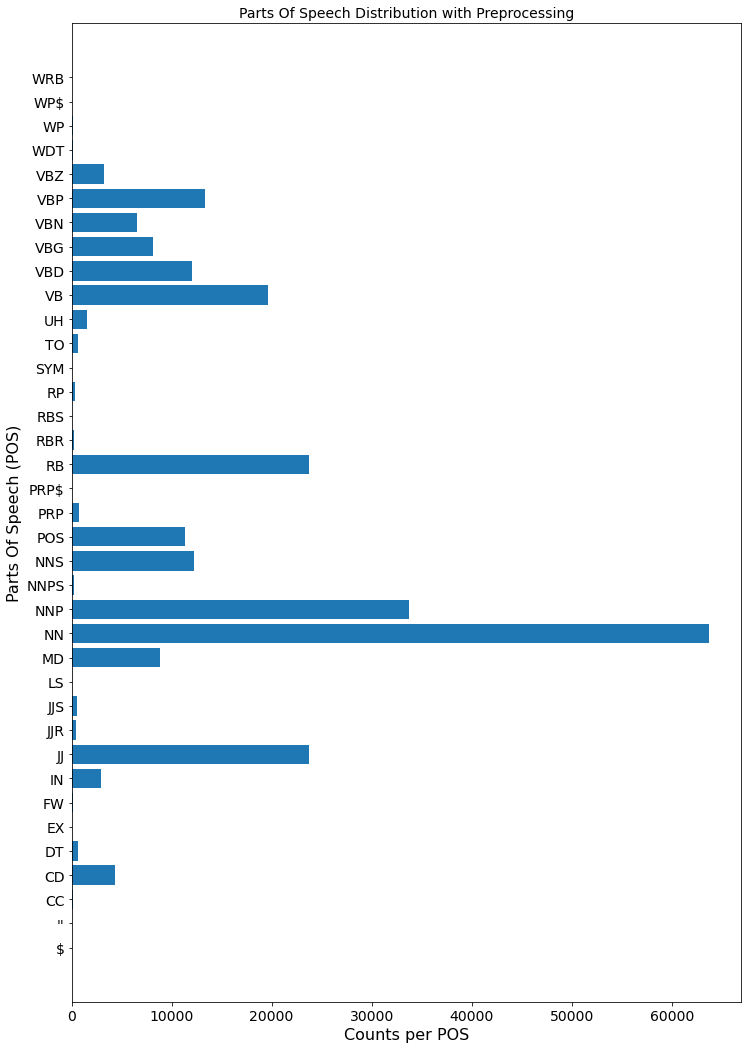

In [83]:
# wanted to get a better understanding of how often the different tags appear

plt.figure(figsize=(12, 18))
plt.barh(*zip(*sorted(count_tags2.items())))
plt.xlabel('Counts per POS')
plt.ylabel('Parts Of Speech (POS)')
plt.title('Parts Of Speech Distribution with Preprocessing')
plt.show()

# Without stop words and punctuation, nouns and proper nouns are the most frequent POS

In [84]:
%%time
# get top 30 Named Entities
all_Tagged2_topNE = getTop30POS(all_Tagged2, regp, label)


Wall time: 1.37 s


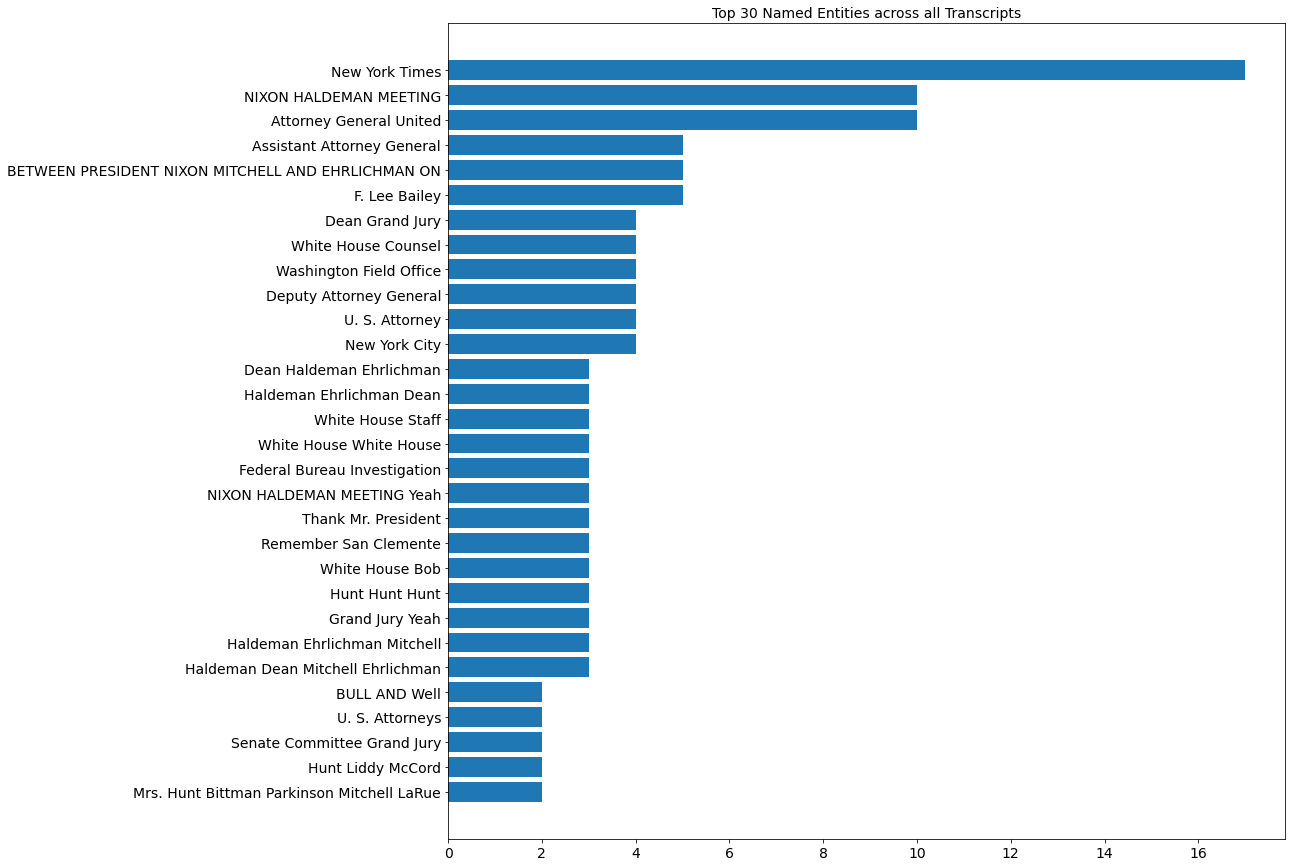

In [85]:
# plot top 30 Named Entities across sentiments
x0, y0 = zip(*(all_Tagged2_topNE))

f, (ax1) = plt.subplots(1, 1, sharex=True, figsize=(15, 15))
#f.subplots_adjust(wspace=1)

ax1.barh(x0,y0)
ax1.set_title("Top 30 Named Entities across all Transcripts");
#f.show()

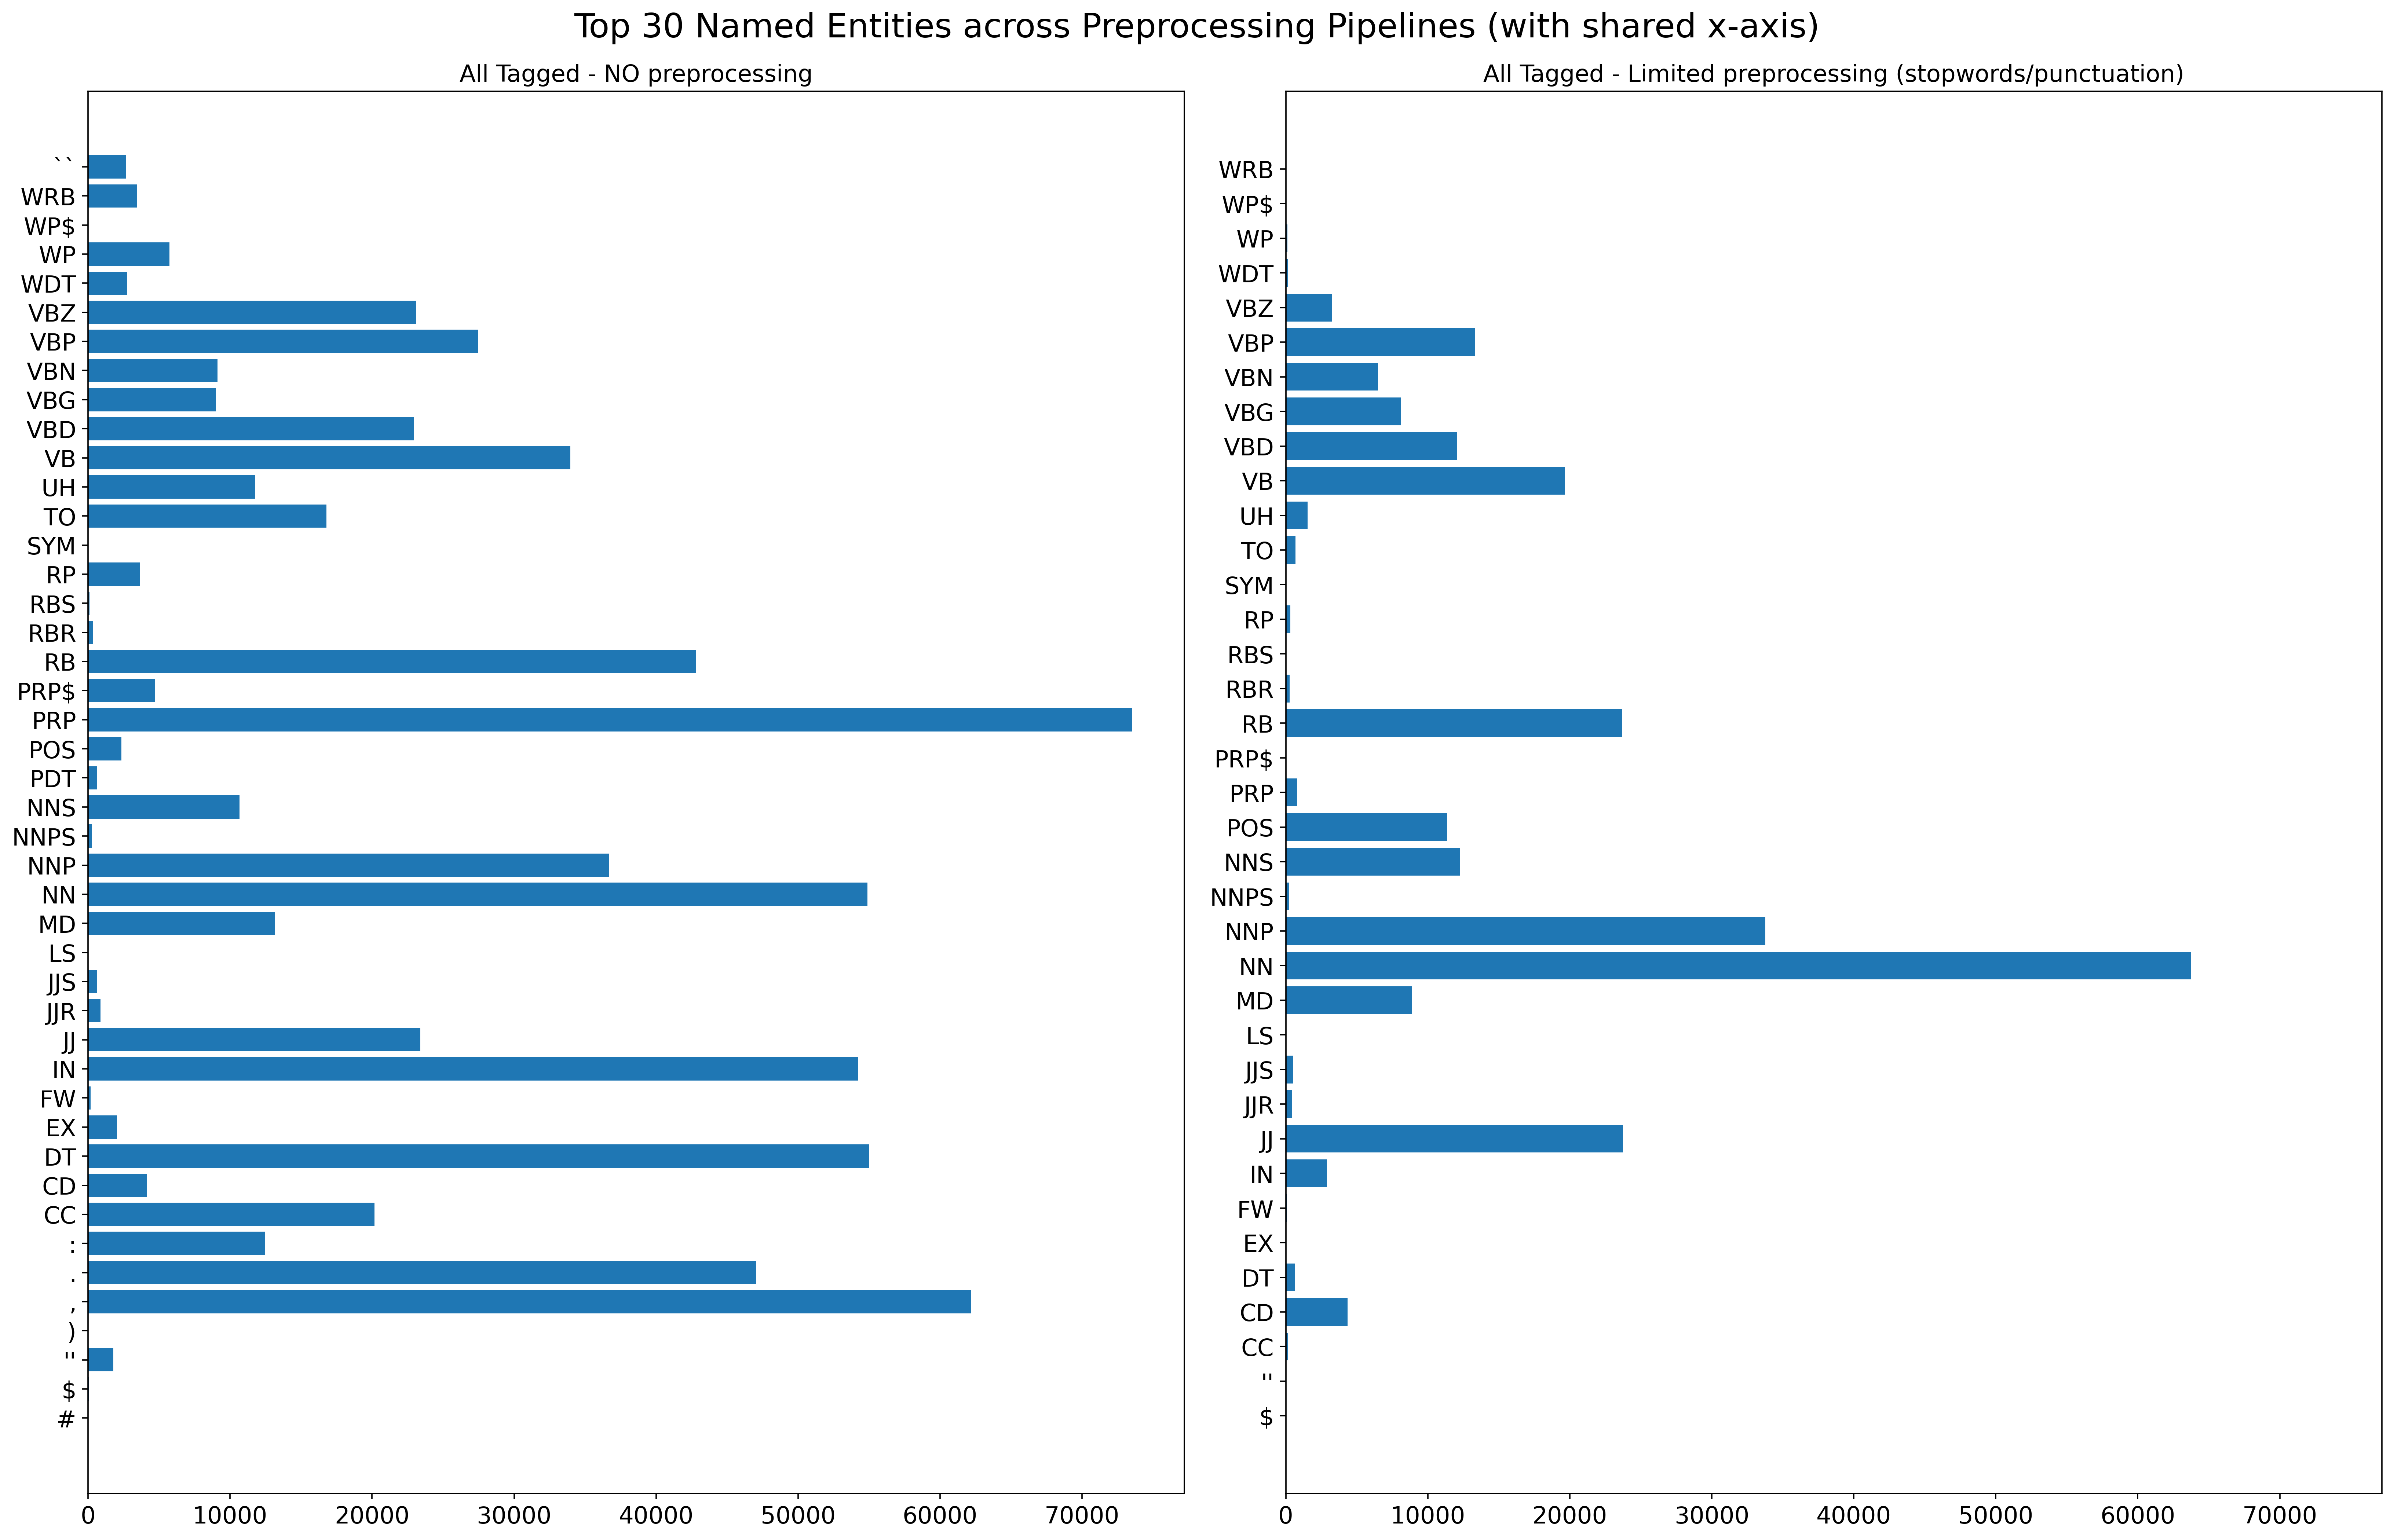

In [87]:
# Plot POS distributions from preprocessing and compare
x0, y0 = zip(*sorted(count_tags.items()))
x1, y1 = zip(*sorted(count_tags2.items()))

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20, 13), dpi=330, tight_layout=True)
f.subplots_adjust(wspace=1)

ax1.barh(x0,y0)
ax1.set_title('All Tagged - NO preprocessing')
ax2.barh(x1,y1)
ax2.set_title('All Tagged - Limited preprocessing (stopwords/punctuation)')
xticklabelsize=20
f.suptitle("Top 30 Named Entities across Preprocessing Pipelines (with shared x-axis)");

#### Explore Named Entities after eliminating stop-words and some punctuation

In [89]:
# plot top 30 Named Entities from preprocessing and compare
x0, y0 = zip(*(all_Tagged_topNE))
x1, y1 = zip(*(all_Tagged2_topNE))

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(30, 20), dpi=330, tight_layout=True)
f.subplots_adjust(wspace=1)

ax1.barh(x0,y0)
ax1.set_title('All Tagged - NO preprocessing', size=26)
ax2.barh(x1,y1)
ax2.set_title('All Tagged - Limited preprocessing', size=26)
ax1.tick_params(labelsize=24)
ax2.tick_params(labelsize=24)
f.suptitle("Top 30 Named Entities across Preprocessing Pipelines (with shared x-axis)", size=32);

## Explore frequent terms

### Explore frequent terms per exhibit

In [90]:
# Create a document-term matrix using CountVectorizer, removing stop_words
cv = CountVectorizer(stop_words=Stop_words)
data_cv = cv.fit_transform(df_all_combined.speech_final)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_dtm.index = df_all_combined.exhibit
data_dtm

,00,000,01,02,05,08,0h,0l,10,100,...,zealots,zeigler,zero,zeroed,zieg1er,ziegler,zielger,zingers,zone,zoning
exhibit,,,,,,,,,,,,,,,,,,,,,
exhibit_12,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
exhibit_13,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
exhibit_14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
exhibit_15,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
exhibit_19,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905-008,2,3,0,0,0,0,0,0,1,1,...,0,1,0,1,0,10,0,0,0,0
431-009,0,7,0,0,0,0,0,0,3,0,...,0,0,0,0,0,16,0,1,0,0
442-001-069,0,0,0,0,1,0,0,0,1,1,...,0,0,1,0,0,25,0,0,0,0


In [91]:
data = data_dtm.transpose()

In [93]:
# Find the top 15 words per exhibit
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(15)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'exhibit_12': [('right', 184),
  ('know', 167),
  ('well', 147),
  ('think', 132),
  ('yeah', 100),
  ('thing', 98),
  ('going', 98),
  ('could', 95),
  ('got', 92),
  ('get', 89),
  ('hunt', 84),
  ('would', 79),
  ('said', 70),
  ('let', 66),
  ('grand', 65)],
 'exhibit_13': [('well', 58),
  ('would', 42),
  ('think', 39),
  ('say', 38),
  ('yeah', 35),
  ('right', 34),
  ('going', 32),
  ('thing', 25),
  ('get', 25),
  ('know', 23),
  ('could', 22),
  ('people', 22),
  ('got', 18),
  ('problem', 17),
  ('report', 17)],
 'exhibit_14': [('know', 19),
  ('yeah', 15),
  ('think', 8),
  ('done', 7),
  ('got', 7),
  ('course', 7),
  ('well', 6),
  ('problem', 6),
  ('mean', 6),
  ('would', 5),
  ('get', 5),
  ('gonna', 5),
  ('want', 5),
  ('sure', 5),
  ('thing', 5)],
 'exhibit_15': [('yeah', 56),
  ('dean', 48),
  ('well', 48),
  ('know', 43),
  ('right', 34),
  ('think', 30),
  ('money', 29),
  ('get', 29),
  ('got', 22),
  ('say', 21),
  ('would', 21),
  ('white', 19),
  ('point', 19

### Explore frequent terms overall

In [94]:
# top 30 terms overall
data_dtm.agg(sum).sort_values(ascending=False)[0:29]

know         4129
well         4043
yeah         3831
think        3774
right        3702
said         3247
get          2458
say          2451
thing        2444
dean         2381
got          2223
would        2217
going        1906
see          1551
one          1458
could        1405
go           1344
want         1314
let          1263
point        1224
john         1156
mean         1149
president    1124
mitchell     1123
ah           1028
way          1024
people        985
told          957
sure          933
dtype: int64